# Ischemic heart disease in Men vs Women
At what age is ischemic heart disease first discovered for men vs women.
Below we have used a synthetic dataset of patient data with 28491 women and 28116 men.

In [356]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""

df = pd.read_sql(query, conn)

## The actual distributions
Below the distributions of the ages, where the disease is discovered for men and women, is graphed.

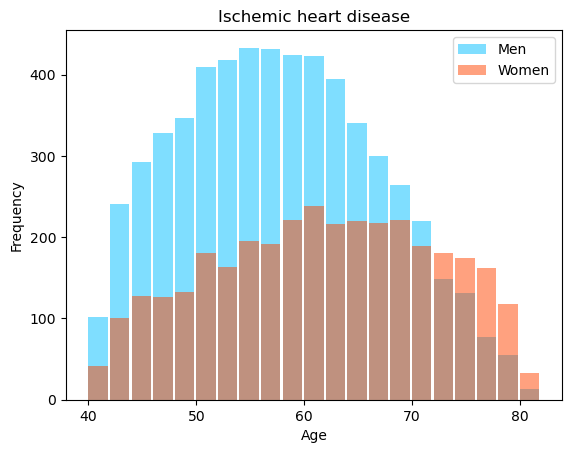

In [357]:
import matplotlib.pyplot as plt
wdf = df.where(df.gender == "F").dropna().groupby(['age', 'gender']).count().reset_index()
mdf = df.where(df.gender == "M").dropna().groupby(['age', 'gender']).count().reset_index()
x = wdf["age"]
y = wdf["patient"]
xmen = mdf["age"]
ymen = mdf["patient"]

plt.bar(xmen, ymen, width=1.8, align='edge', label='Men', alpha=0.5, color='deepskyblue')
plt.bar(x, y, width=1.8, align='edge', label='Women', alpha=0.5, color='orangered')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ischemic heart disease')
plt.legend()
plt.show()

Mens distribution peaks earlier than the womens and there seem to be more cases for men. Around age 55 for men and 62 for women. These are properties we would like to persist after differential privacy is applied.

## With DP
Below we use openDP to apply noise to the queries.

In [358]:
import snsql
from snsql import Privacy

metadata = {
    '':{
        '': {
            'MyTable': {
                'max_ids': 1,
                'row_privacy': True,
                'patient': {
                    'name': 'patient',
                    'type': 'string'
                },
                'age': {
                    'name': 'age',
                    'type': 'int'
                },
                'gender': {
                    'name': 'gender',
                    'type': 'string'
                }
            }
        }
    }
}

privacy = Privacy(epsilon=0.1, delta=1)
reader = snsql.from_connection(df, privacy=privacy, metadata=metadata)

/Users/lukas/opt/anaconda3/lib/python3.9/site-packages/snsql/sql/private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider doing the dimension
censoring as a preprocessing step.  See the documentation for more information.
  warnings.warn(


We run the dp mechanism 1000 times and find the min and max frequencies for all ages which we then plot.

In [359]:
values = []
wMeans = []
mMeans = []
for i in range(100):
    r = reader.execute('SELECT gender, age, COUNT(patient) as amount FROM MyTable GROUP BY gender, age')[1:]
    wSum = 0
    wMean = 0
    mSum = 0
    mMean = 0
    #calculate mean for women and men
    for j, e in enumerate(r):
        a = e[1]
        v = e[2]
        if e[0] == 'F':
            wSum = wSum + v
            wMean = wMean + (a * v)
        else:
            mSum = mSum + v
            mMean = mMean + (a * v)
    wMeans.append(wMean / wSum)
    mMeans.append(mMean / mSum)
    for j, e in enumerate(r):
        v = e[2]
        if len(values) <= j:
            values.append([])
        values[j].append(v)

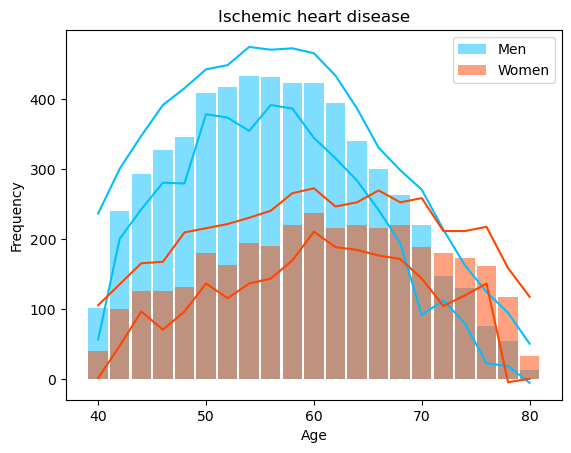

In [360]:
minvalues = [None] * len(values)
maxvalues = [None] * len(values)
for i in range(len(values)):
    minvalues[i] = min(values[i])
    maxvalues[i] = max(values[i])
plt.bar(xmen, ymen, width=1.8, align='center', label='Men', alpha=0.5, color='deepskyblue')
plt.bar(x, y, width=1.8, align='center', label='Women', alpha=0.5, color='orangered')
plt.plot(x, maxvalues[21:], color='deepskyblue')
plt.plot(x, minvalues[21:], color='deepskyblue')
plt.plot(x, maxvalues[:21], color='orangered')
plt.plot(x, minvalues[:21], color='orangered')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ischemic heart disease')
plt.legend()
plt.show()

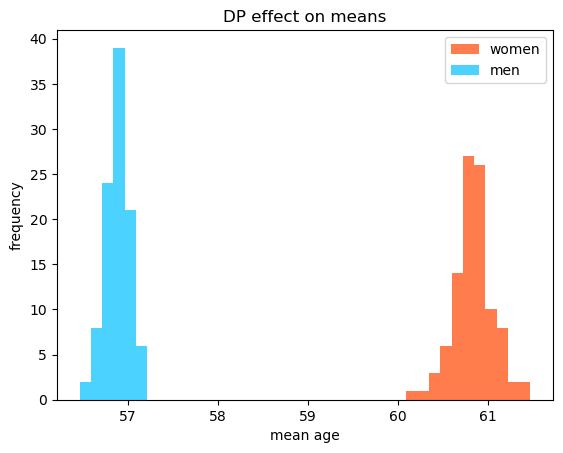

In [368]:
import numpy as np

plt.cla()
bins=np.histogram(np.hstack((wMeans,mMeans)), bins=40)[1]
plt.hist(wMeans, bins, color='orangered', label='women', alpha=0.7)
plt.hist(mMeans, bins, color='deepskyblue', label='men', alpha=0.7)
plt.xlabel('mean age')
plt.ylabel('frequency')
plt.title('DP effect on means')
plt.legend()
plt.show()

## Randomized response (local DP)
Below we look at how the count of men vs women with Ischemic heart disease would be effected if the data was gathered using randomized response (coin flipping).

In [362]:
# Recurrent urinary tract infection

falseQuery = """
SELECT GENDER, Id
FROM patients
WHERE Id NOT IN (
    SELECT DISTINCT PATIENT
    FROM conditions
    WHERE DESCRIPTION = 'Ischemic heart disease (disorder)'
);
"""
trueQuery = """
SELECT GENDER, Id
FROM patients
WHERE Id IN (
    SELECT DISTINCT PATIENT
    FROM conditions
    WHERE DESCRIPTION = 'Ischemic heart disease (disorder)'
);
"""

falsedf = pd.read_sql(falseQuery, conn)
truedf = pd.read_sql(trueQuery, conn)

In [363]:
import random as rand

def randomizedResponse(truth):
    if rand.random() < 0.5:
        return truth
    else:
        return rand.random() < 0.5

def rr(yesses, all):
    nos = all - yesses
    rand = 0

    for x in range(yesses):
        if randomizedResponse(True):
            rand = rand + 1
    for x in range(nos):
        if randomizedResponse(False):
            rand = rand + 1

    fakeYesses = all / 4
    return (rand - fakeYesses) * 2

In [364]:
wCounts = []
mCounts = []
for i in range(100):
    womenCount = rr(len(truedf.where(truedf.GENDER == 'F').dropna()), len(falsedf.where(falsedf.GENDER == 'F').dropna()))
    menCount = rr(len(truedf.where(truedf.GENDER == 'M').dropna()), len(falsedf.where(falsedf.GENDER == 'M').dropna()))
    wCounts.append(womenCount)
    mCounts.append(menCount)

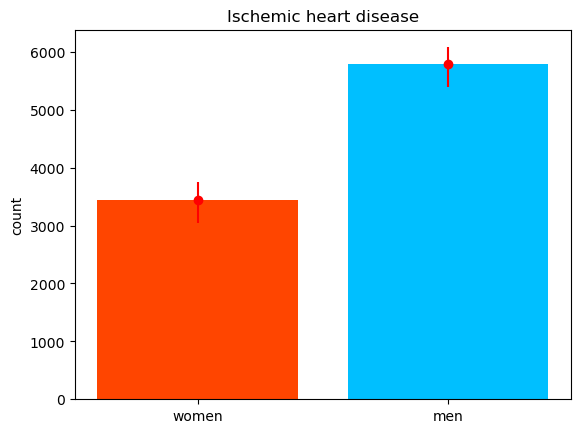

In [365]:
wc = len(truedf.where(truedf.GENDER == 'F').dropna())
mc = len(truedf.where(truedf.GENDER == 'M').dropna())

fig, ax = plt.subplots()

genders = ['women', 'men']
counts = [wc, mc]
bar_colors = ['orangered', 'deepskyblue']

ax.bar(genders, counts, color=bar_colors)

ax.set_ylabel('count')
ax.set_title('Ischemic heart disease')
plt.errorbar(genders, counts, yerr=[[wc - min(wCounts), mc - min(mCounts)], [max(wCounts) - wc, max(mCounts) - mc]], fmt="o", color="r")

plt.show()

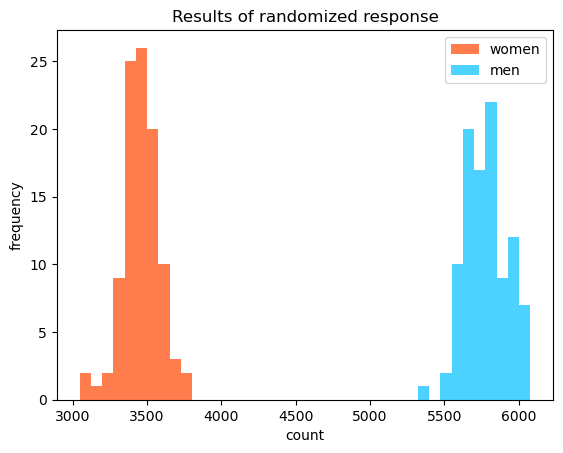

In [366]:
plt.cla()
bins=np.histogram(np.hstack((wCounts,mCounts)), bins=40)[1]
plt.hist(wCounts, bins, color='orangered', label='women', alpha=0.7)
plt.hist(mCounts, bins, color='deepskyblue', label='men', alpha=0.7)
plt.xlabel('count')
plt.ylabel('frequency')
plt.title('Results of randomized response')
plt.legend()
plt.show()